# Project 4: Advanced Lane Finding
## Joseph Rogers
## Udacity Self-Driving Car Nanodegree
This Jupyter notebook goes through the whole pipeline of loading in a video file, analyzing the lane positions, and writing out a new video with colored lane markers

## 1) Import Some Basic Things

In [6]:
# Import Necessary Addons
import pickle
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os, os.path # Get directory info

# Get the list of all files in the directory
DIR = './camera_cal/'
image_names = [name for name in os.listdir(DIR) if os.path.isfile(os.path.join(DIR, name))]


nx = 9 # the number of inside corners in x
ny = 6 # the number of inside corners in y
images = []
grays = []
imgpoints = []
objpoints = []

# Static object points that will be used for the perspective transforms
objp = np.zeros((ny*nx,3), np.float32)
objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1,2)

## 2) Define the Lane() class that will be used to store old lane data

In [7]:
class Lane():
    def __init__(self):       
        # x and y values for new detected line pixels each frame
        self.new_left_fitx = None  
        self.new_right_fitx = None
        
        # History of the detected lines for the last five frames
        self.leftx_history = [0,0,0,0,0]
        self.rightx_history = [0,0,0,0,0]
        
        
        # Avg positions of the last 5 lanes
        self.avg_leftx = [0]
        self.avg_rightx = [0]
        
        
        #radius of curvature of the line in some units
        self.radius_of_curvature = 0
        self.radius_of_curvature_history = [0,0,0,0,0] 
        self.avg_radius_of_curvature = 0
        
lane_info = Lane()

## 3) Read in all Calibration Images and Display them

./camera_cal/calibration18.jpg
./camera_cal/calibration1.jpg
./camera_cal/calibration12.jpg
./camera_cal/calibration10.jpg
./camera_cal/calibration16.jpg
./camera_cal/calibration13.jpg
./camera_cal/calibration17.jpg
./camera_cal/calibration11.jpg
./camera_cal/calibration2.jpg
./camera_cal/calibration3.jpg
./camera_cal/calibration14.jpg
./camera_cal/calibration5.jpg
./camera_cal/calibration9.jpg
./camera_cal/calibration8.jpg
./camera_cal/calibration4.jpg
./camera_cal/calibration7.jpg
./camera_cal/calibration19.jpg
./camera_cal/calibration20.jpg
./camera_cal/calibration15.jpg
./camera_cal/calibration6.jpg


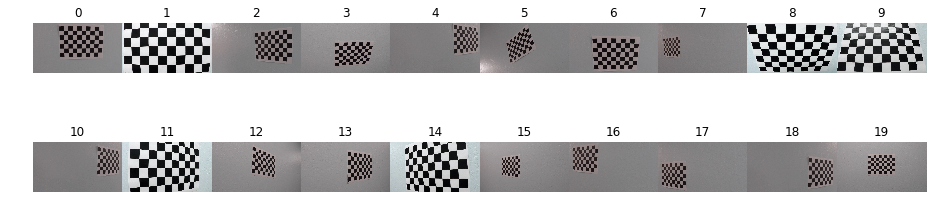

In [8]:
# Read in all images
for i in range (len(image_names)):
    filename = DIR + image_names[i]
    image = cv2.imread(DIR + image_names[i])
    images.append(image)
    grays.append(cv2.cvtColor(image, cv2.COLOR_BGR2GRAY))
    ret, corners = cv2.findChessboardCorners(grays[i], (nx, ny), None)


    # Add points if corners are detected
    if ret == True:
        imgpoints.append(corners)
        objpoints.append(objp)

    print(filename)

    
# Set up subplot details
fig, axs = plt.subplots(2,10, figsize=(16, 4))
fig.subplots_adjust(hspace = .2, wspace=.001)
axs = axs.ravel()

# Plot all of the Calibration Images
for i in range(20):
    image = images[i]
    axs[i].axis('off')
    axs[i].imshow(image, cmap='gray')
    axs[i].set_title(i)
plt.show()

## 4) Define Undistort Function, get Camera Matrix and print some test images

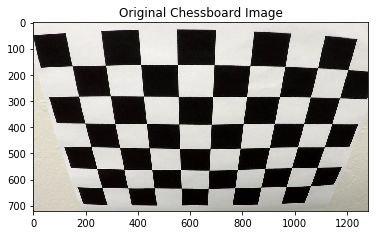

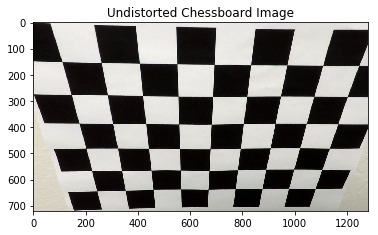

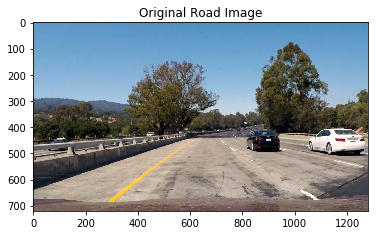

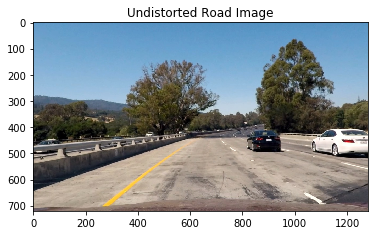

In [9]:
def cal_undistort(img, objpoints, imgpoints):
    # Use cv2.calibrateCamera() and cv2.undistort()
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, grays[2].shape[::-1], None, None)
    dst = cv2.undistort(img, mtx, dist, None, mtx)
    return dst


# Original Chessboard
plt.imshow(cv2.cvtColor(images[8], cv2.COLOR_BGR2RGB))
plt.title("Original Chessboard Image")
plt.show()

# Undistorted Chessboard
undistorted_chess = cal_undistort(images[8], objpoints, imgpoints)
plt.imshow(cv2.cvtColor(undistorted_chess, cv2.COLOR_BGR2RGB))
plt.title("Undistorted Chessboard Image")
plt.show()

# Original Road
#original_road = cv2.imread('./test_images/straight_lines2.jpg')
original_road = cv2.imread('./test_images/test1.jpg')
plt.imshow(cv2.cvtColor(original_road, cv2.COLOR_BGR2RGB))
plt.title("Original Road Image")
plt.show()

# Undistorted Road
undistorted_road = cal_undistort(original_road, objpoints, imgpoints)
plt.imshow(cv2.cvtColor(undistorted_road, cv2.COLOR_BGR2RGB))
plt.title("Undistorted Road Image")
plt.show()

## 5) Use Color Transforms, Gradients, Thresholds, etc... to get a Good Binary Image

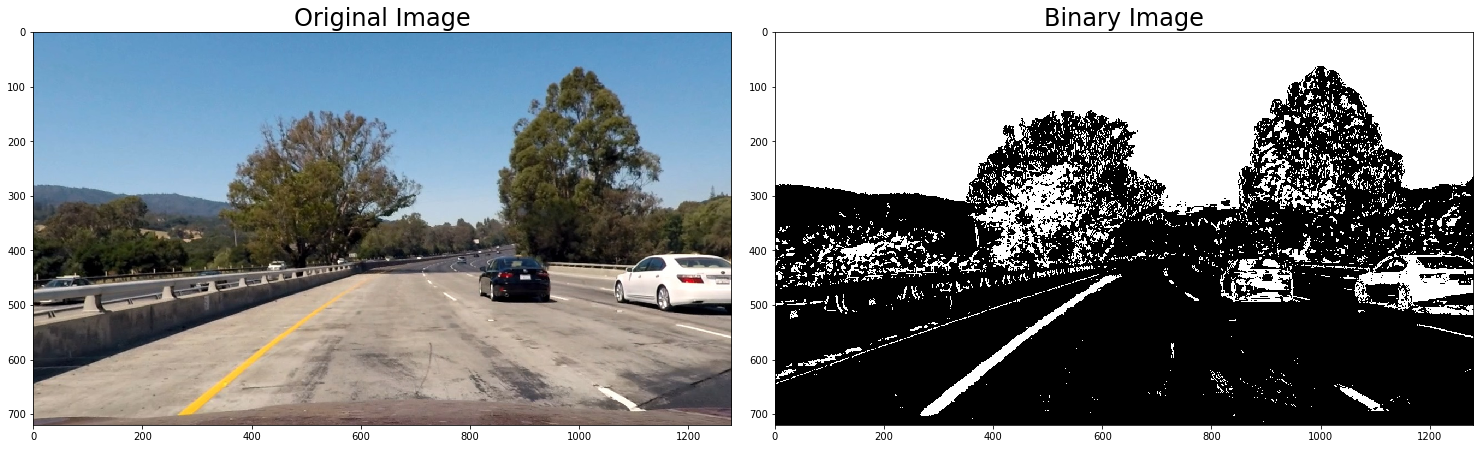

In [10]:
# Make a copy of the undistorted road test image
image = np.copy(undistorted_road)

# Function for converting BGR images to binary
def binaryImage(img, s_thresh=(90, 255), sx_thresh=(30, 150)):
    
    # Convert to HLS color space and separate the V channel
    img = np.copy(img)
    hls = cv2.cvtColor(img, cv2.COLOR_BGR2HLS).astype(np.float)
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    
    # Sobel x
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    
    # Stack each channel
    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary)) * 255
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1
    
    return combined_binary



binary_image = binaryImage(image)

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
f.tight_layout()

ax1.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
ax1.set_title('Original Image', fontsize=24)

ax2.imshow(binary_image, cmap='gray')
ax2.set_title('Binary Image', fontsize=24)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

plt.show()

## 6) Draw Lines to be used for Perspective Transform

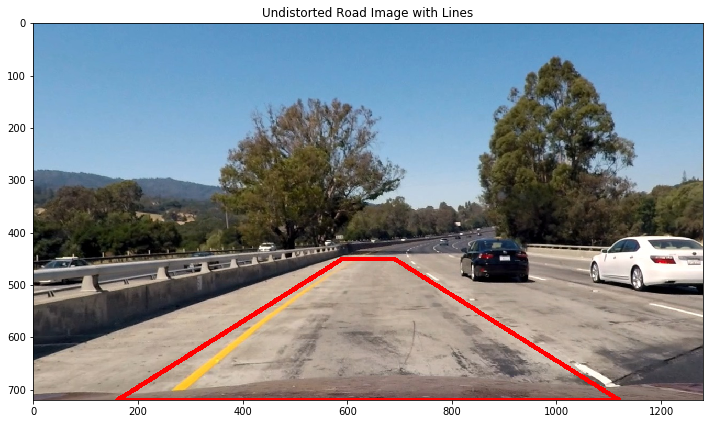

In [11]:
lined_image = np.copy(image)
lined_image = cv2.cvtColor(lined_image, cv2.COLOR_BGR2RGB)

# Draw the source points

# Source region attributes
bottom_left   = (160, 720)
top_left      = (590, 450)
top_right     = (690, 450)
bottom_right  = (1120, 720)
lineThickness = 7
line_color    = (255, 0, 0)

# Left line
cv2.line(lined_image, bottom_left, top_left, line_color, lineThickness)
# Right line
cv2.line(lined_image, bottom_right, top_right, line_color, lineThickness)
# Bottom line
cv2.line(lined_image, bottom_left, bottom_right, line_color, lineThickness)
# Top line
cv2.line(lined_image, top_left, top_right, line_color, lineThickness)

plt.figure(figsize=(12,12))
plt.imshow(lined_image, cmap='gray')
plt.title("Undistorted Road Image with Lines")
plt.show()

## 7) Perform Perspective Transform to "bird's eye view" of Lanes

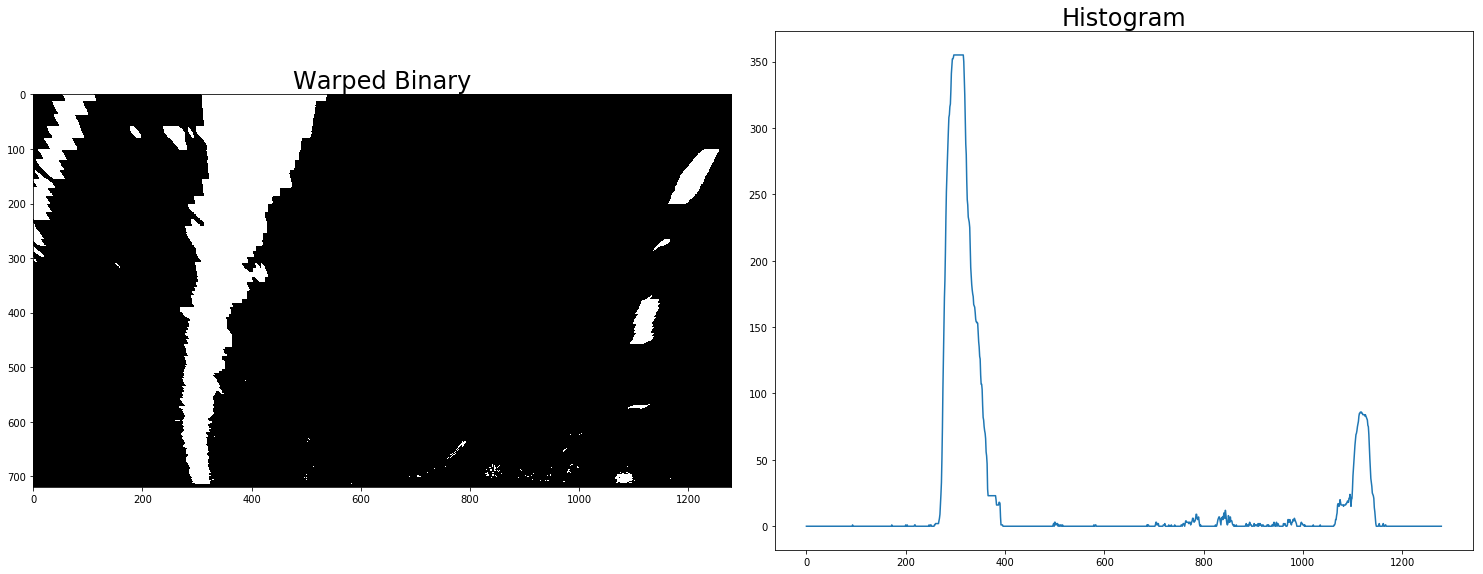

In [12]:
# Destination points for the warp
point1 = [230,720]
point2 = [230,0]
point3 = [1050,0]
point4 = [1050,720]

road_src_points = np.array([list(bottom_left), list(top_left), list(top_right), list(bottom_right)],np.float32)
road_dst_points = np.array([point1, point2, point3, point4],np.float32)


binary_warped = np.copy(lined_image)
img_size = (image.shape[1], image.shape[0])
M = cv2.getPerspectiveTransform(road_src_points, road_dst_points)


def warpImage(image, img_size, src, dst, M):
    result = cv2.warpPerspective(image, M, img_size)
    return result



# Bird's Eye Road
test_warp = warpImage(binary_image, img_size, road_src_points, road_dst_points, M)
# Histogram
histogram = np.sum(test_warp[test_warp.shape[0]//2:,:], axis=0)


# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
f.tight_layout()

ax1.imshow(test_warp, cmap='gray')
ax1.set_title('Warped Binary', fontsize=24)

ax2.plot(histogram)
ax2.set_title('Histogram', fontsize=24)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

plt.show()

## 8) Detect lane pixels and fit to find the lane boundary. (Regular Search)

In [27]:
def detectLanes(binary_warped):
    global lane_info
    
    # Assuming you have created a warped binary image called "binary_warped"
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    #np.sum(test_warp[test_warp.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 12
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 20
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
        (0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
        (0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)



    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    
    
    
    # Get lane curvature
    y_eval = np.max(ploty)
    
    
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
    
    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(ploty*ym_per_pix, left_fitx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, right_fitx*xm_per_pix, 2)
    
    
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    
    
    # Assign curvatures to the line classes
    avg_curve = (left_curverad + right_curverad)/2
    lane_info.radius_of_curvature = round(avg_curve,2)
    
    
    # Calculate vehicle position in the lane
    img_size = (binary_warped.shape[1], binary_warped.shape[0])
    center = img_size[0]/2
    left_dist = center - left_fitx[-1]
    right_dist = center - right_fitx[-1]
    lane_diff = abs(left_fitx[-1] - right_fitx[-1])
    
    
    # Update some lane info
    lane_position = (left_dist + right_dist) * xm_per_pix # Meter from lane center
    lane_info.line_base_pos = round(lane_position, 2)
    
    
    
    
    ##########################################################
    # Uncomment this section to see the test image
    ##########################################################
    '''
    # Test Plots
    plt.figure(figsize=(16,16))
    plt.imshow(out_img, cmap='gray')
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    plt.title("Detected Lanes and fitted polynomials")
    plt.show()
    '''
    
    
    
    return left_fitx, right_fitx, left_fit, right_fit




left_fitx, right_fitx, left_fit, right_fit = detectLanes(test_warp)

## 9) Faster Local Search for next frame

In [28]:
def detectLanesFast(binary_warped, left_fit, right_fit):
    global lane_info
    
    # Assume you now have a new warped binary image 
    # from the next frame of video (also called "binary_warped")
    # It's now much easier to find line pixels!
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 40
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
    left_fit[1]*nonzeroy + left_fit[2] + margin))) 

    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
    right_fit[1]*nonzeroy + right_fit[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    # Get lane curvature
    y_eval = np.max(ploty)
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(ploty*ym_per_pix, left_fitx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, right_fitx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    # Now our radius of curvature is in meters
    
    # Assign curvatures to the line classes
    avg_curve = (left_curverad + right_curverad)/2
    lane_info.radius_of_curvature = round(avg_curve,2)
    
    # Calculate vehicle position in the lane
    img_size = (binary_warped.shape[1], binary_warped.shape[0])
    center = img_size[0]/2
    left_dist = center - left_fitx[-1]
    right_dist = center - right_fitx[-1]
    lane_diff = abs(left_fitx[-1] - right_fitx[-1])
    
    
    lane_position = (left_dist + right_dist) * xm_per_pix # Meter from lane center
    lane_info.line_base_pos = round(lane_position, 2)
    
    
    
    
    ##########################################################
    # Uncomment this section to see the test image
    ##########################################################
    '''
    # Test Plots
    plt.figure(figsize=(16,16))
    plt.imshow(out_img, cmap='gray')
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    plt.title("Detected Lanes and fitted polynomials")
    plt.show()
    '''
    
    
    
    
    return left_fitx, right_fitx, left_fit, right_fit

# Just testing the function
left_fitx2, right_fitx2, left_fit2, right_fit2 = detectLanesFast(binary_warped, left_fit, right_fit)

## 10) Update Lane Curves function

In [29]:
count = 0

def updateCurves(left_fitx, right_fitx):
    global count
    
    # Put latest value into object
    lane_info.new_left_fitx = left_fitx
    lane_info.new_right_fitx = right_fitx
    
        
    # Write over oldest value in list
    lane_info.leftx_history[count%5] = lane_info.new_left_fitx
    lane_info.rightx_history[count%5] = lane_info.new_right_fitx
    lane_info.radius_of_curvature_history[count%5] = lane_info.radius_of_curvature

    
    # Calculate new averages
    lane_info.avg_leftx = (sum(lane_info.leftx_history)/(len(lane_info.leftx_history)))
    lane_info.avg_rightx = (sum(lane_info.rightx_history)/(len(lane_info.rightx_history)))
    lane_info.avg_radius_of_curvature = (sum(lane_info.radius_of_curvature_history)/(len(lane_info.radius_of_curvature_history)))
    
    
updateCurves(left_fitx, right_fitx)

## 11) Create and apply lane colors

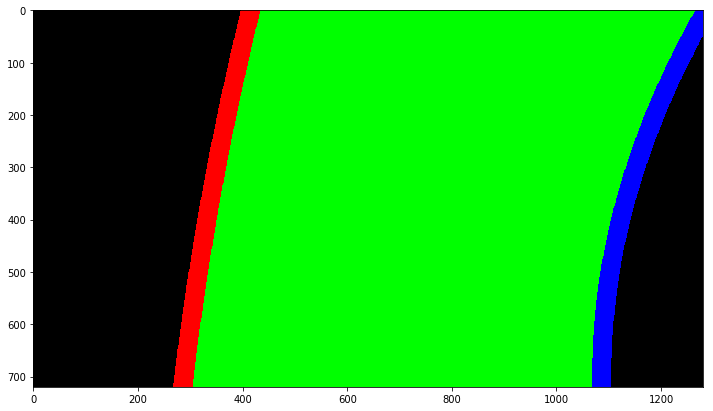

In [30]:
def colorRoad(image, left_fitx, right_fitx):
    # Creat black convas
    warp_color_overlay = np.copy(image * 0)
    
    ploty = np.linspace(0, warp_color_overlay.shape[0]-1, warp_color_overlay.shape[0])
    pts_left = 0
    pts_right = 0
    # Create the left and right drawing areas
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    # Middle Area
    pts = 0
    pts = np.hstack((pts_left, pts_right))
    cv2.fillPoly(warp_color_overlay, np.int_([pts]), (0,255, 0))
    
    cv2.polylines(warp_color_overlay, np.int32([pts_left]), isClosed=False, color=(255,0,0), thickness=35)
    cv2.polylines(warp_color_overlay, np.int32([pts_right]), isClosed=False, color=(0,0,255), thickness=35)
    #warp_color_overlay = cv2.addWeighted(warp_color_overlay, 1, warp_color_overlay, 0.3, 0)
    result = warp_color_overlay
    
    return result
    
plt.figure(figsize=(12,12))
warp_color_overlay = colorRoad(image, left_fitx, right_fitx)
plt.imshow(warp_color_overlay)
plt.show()

## 12) Reverse Transform Back to Road Surface

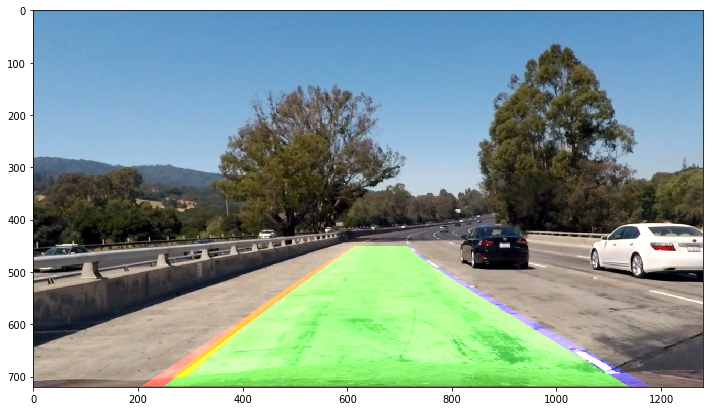

In [31]:
image = cv2.cvtColor(undistorted_road, cv2.COLOR_BGR2RGB)
color_overlay = np.copy(image*0)
img_size = (image.shape[1], image.shape[0])
M = cv2.getPerspectiveTransform(road_dst_points, road_src_points)


# Tranform and overlay on road function
def transToRoad(image, warped_color_overlay, M):
    img_size = (image.shape[1], image.shape[0])
    color_overlay = cv2.warpPerspective(warped_color_overlay, M, img_size)
    result = cv2.addWeighted(image, 1, color_overlay, 0.5, 0)
    
    return result


test_final = np.copy(image) * 0
test_final = transToRoad(image, warp_color_overlay, M)
plt.figure(figsize=(12,12))
plt.imshow(test_final)
plt.show()

## 13) Write text on to image frame

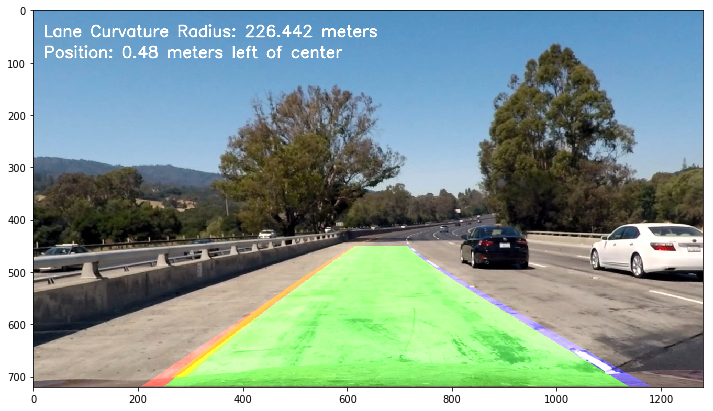

In [32]:
def writeText(image):
    global lane_info
    
    # Pull info from the lane object
    avg_curve = lane_info.avg_radius_of_curvature
    lane_position = lane_info.line_base_pos
    
    # Text Settings
    font = cv2.FONT_HERSHEY_SIMPLEX
    font_scale = 1
    font_color = (255,255,255)
    line_type = 2
    
    
    # Add text to image frame
    cv2.putText(image, 'Lane Curvature Radius: ' + str(avg_curve) + ' meters', (20,50), font, font_scale, font_color, line_type, cv2.LINE_AA)
    if lane_position < 0:
        cv2.putText(image, 'Position: ' + str(abs(lane_position)) + ' meters left of center', (20,90), font, font_scale, font_color, line_type, cv2.LINE_AA)
    else:
        cv2.putText(image, 'Position: ' + str(abs(lane_position)) + ' meters right of center', (20,90), font, font_scale, font_color, line_type, cv2.LINE_AA)

        
    
    return image

plt.figure(figsize=(12,12))
final_image = writeText(test_final)
plt.imshow(final_image)
plt.show()

## 14) Define full image processing pipeline

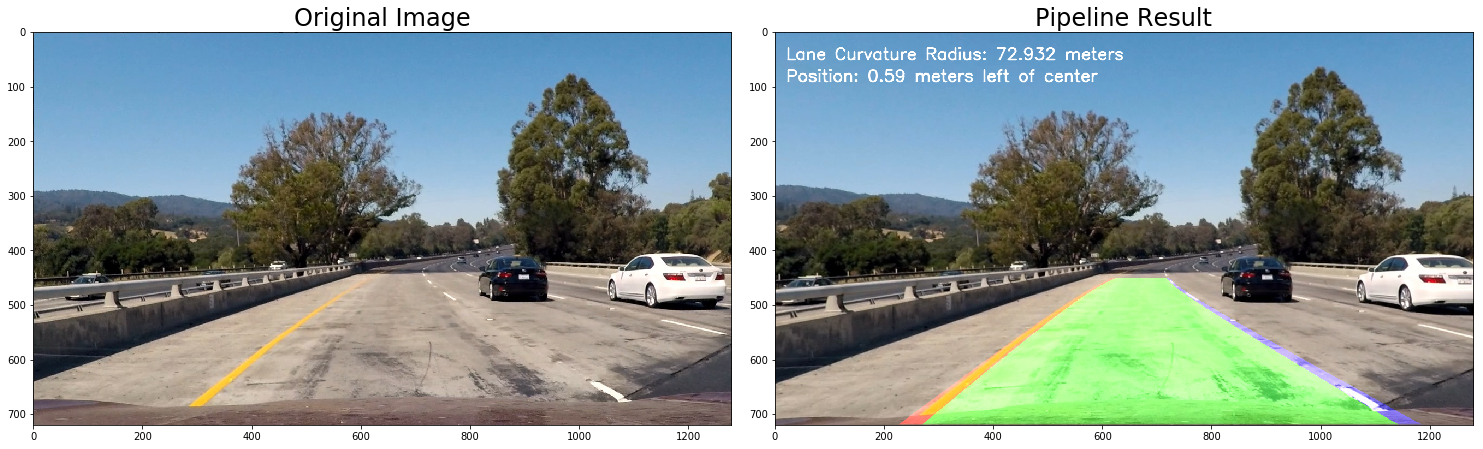

In [33]:
import time

count = 0 # Reset global count for testing

def process_image(image):
    # Count used for performing some operations only on certain frames
    global count
    
    # Set some initial values
    global left_fitx
    global right_fitx 
    global left_fit
    global right_fit
    
    # Lane data
    global lane_info
    
    
    # Define source points from which to transform
    bottom_left   = (160, 720)
    top_left      = (590, 450)
    top_right     = (690, 450)
    bottom_right  = (1120, 720)
    src = np.array([list(bottom_left), list(top_left), list(top_right), list(bottom_right)],np.float32) # Points at the start
    
    
    # Define destination transform points
    point1 = [230,720]
    point2 = [230,0]
    point3 = [1050,0]
    point4 = [1050,720]
    dst = np.array([point1, point2, point3, point4],np.float32) # Points after transform
    
    
    # Get image size and perspective transform properties
    img_size = (image.shape[1], image.shape[0])
    M = cv2.getPerspectiveTransform(src, dst)      # Forward transform matrix
    RM = cv2.getPerspectiveTransform(dst, src)     # Reverse transform matrix
    
    
    
    
    #######################################################################
    # START OF ACTUAL IMAGE PROCESSING PIPELINE HERE!
    #######################################################################
    
    
    # 1) Undistort the image frame
    undistort = cal_undistort(image, objpoints, imgpoints)
    
    
    # 2) Convert the image to binary
    binary = binaryImage(undistort, (170, 255), (20, 100))
    
    
    # 3) Warp the binary image to "bird's eye view"
    binary_warped = warpImage(binary, img_size, src, dst, M)
    
    
    # 4) Detect lane lines on the warped binary image
    if (count > 0):
        left_fitx, right_fitx, left_fit, right_fit = detectLanesFast(binary_warped, left_fit, right_fit)
    else:
        left_fitx, right_fitx, left_fit, right_fit = detectLanes(binary_warped)
    
    
    # 5) Update the lane info with data from the lane dectection
    updateCurves(left_fitx, right_fitx)

    
    # 6) Add colors to the lane area
    if (count < 5):
        warped_color = colorRoad(image, left_fitx, right_fitx)
    else:
        warped_color = colorRoad(image, lane_info.avg_leftx, lane_info.avg_rightx)

        
    # 7) Warp back to regular perspective
    colored_road = transToRoad(undistort, warped_color, RM)
    
    
    # 8) Add text details to the image
    final_image = writeText(colored_road)
    
    
    # 9) Update the frame count
    count = count + 1
   

    return final_image



# Test running the pipeline on a test image
test_image = cv2.imread('./test_images/test1.jpg')
test_image = cv2.cvtColor(test_image, cv2.COLOR_BGR2RGB)
pipeline_test = process_image(test_image)


# Plot the results os the pipeline test
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
f.tight_layout()

ax1.imshow(test_image)
ax1.set_title('Original Image', fontsize=24)

ax2.imshow(pipeline_test, cmap='gray')
ax2.set_title('Pipeline Result', fontsize=24)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

plt.show()

## 15) Process Video Through Pipeline

In [34]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML
import imageio
imageio.plugins.ffmpeg.download()
from moviepy.editor import *

# Set frame counter to 0
count = 0

# Create new lane_info object
lane_info = Lane()

video_output = './output_images/project_video_test.mp4'
video_clip = VideoFileClip('./project_video.mp4')
#video_clip = video_clip.fl_image(process_image).subclip(40,44)
video_clip = video_clip.fl_image(process_image)
%time video_clip.write_videofile(video_output, audio=False)

[MoviePy] >>>> Building video ./output_images/project_video_test.mp4
[MoviePy] Writing video ./output_images/project_video_test.mp4



 12%|█▏        | 152/1261 [01:25<09:57,  1.86it/s]


 24%|██▍       | 303/1261 [02:50<09:41,  1.65it/s]


 36%|███▌      | 454/1261 [04:13<07:11,  1.87it/s]


 48%|████▊     | 605/1261 [05:36<06:03,  1.80it/s]


 60%|█████▉    | 756/1261 [07:03<04:31,  1.86it/s]


 72%|███████▏  | 907/1261 [08:26<03:09,  1.87it/s]


 84%|████████▍ | 1057/1261 [09:50<01:49,  1.87it/s]


 96%|█████████▌| 1205/1261 [11:12<00:33,  1.68it/s]


100%|█████████▉| 1260/1261 [11:42<00:00,  1.81it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./output_images/project_video_test.mp4 

CPU times: user 17min 36s, sys: 12.3 s, total: 17min 48s
Wall time: 11min 43s
